In [1]:
%reload_ext autoreload
%autoreload 2

# %gui qt

import time
from tqdm import tqdm
from pathlib import Path
import numpy as np
import numba as nb
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

import vrExperiment as vre
import vrFunctions as vrf
import basicFunctions as bf
import fileManagement as fm
import dbManagement as dbm

# import redCellGUI as rgui

In [6]:
# Immediate next steps for programming work:
# - ROICaT index alignment tools

In [2]:
mouseName = 'CR_Hippocannula6'
dateString = '2022-09-05'
session = '701'
# vrExperiment registration and preprocessing 
# vrReg = vre.vrExperimentRegistration(mouseName, dateString, session, oasis=False, imaging=True)
# vrReg.processTimeline()
# vrReg.processImaging()
# vrReg.processRedCells()
# vrReg.saveParams()
# print(vrReg.sessionPath())
# del vrReg

In [2]:
mouseName = 'ATL020'
dateString = '2023-05-04'
session = '702'

In [28]:
# vrExperiment registration and preprocessing 
vrReg = vre.vrExperimentRegistration(mouseName, dateString, session, oasis=False, imaging=True)
vrReg.doPreprocessing()
vrReg.saveParams()
print(vrReg.sessionPath())
del vrReg

In session: ATL020/2023-05-04/702, vrFile['rigInfo'] does not exist. Assuming default settings for B2!
Self.value['numTrials'] set by trialInfo.trialIdx>0, but this might not be right. There might be smarter ways to determine which trials are 'good' trials...
frame2time had 2 more than suite2p output. This happens sometimes. I don't like it. I think it's because scanimage sends a TTL before starting the frame
ATL020/2023-05-04/702:spks shapes: [1233, 421, 1105, 1915, 1341]
ATL020/2023-05-04/702:roiPerPlane: [1233, 421, 1105, 1915, 1341]
ATL020/2023-05-04/702:F shapes: [1233, 421, 1105, 1915, 1341]
ATL020/2023-05-04/702:roiPerPlane: [1233, 421, 1105, 1915, 1341]
ATL020/2023-05-04/702:Fneu shapes: [1233, 421, 1105, 1915, 1341]
ATL020/2023-05-04/702:roiPerPlane: [1233, 421, 1105, 1915, 1341]
ATL020/2023-05-04/702:redcell shapes: [1233, 421, 1105, 1915, 1341]
ATL020/2023-05-04/702:roiPerPlane: [1233, 421, 1105, 1915, 1341]
ATL020/2023-05-04/702:iscell shapes: [1233, 421, 1105, 1915, 1341]


In [5]:
# Load registered vrExperiment
vrexp = vre.vrExperiment(mouseName, dateString, session)

In [12]:
iscell = vrexp.loadS2P('iscell', concatenate=True, checkVariables=False)
redcell = vrexp.loadS2P('redcell', concatenate=True, checkVariables=False)
np.unique(redcell[:,0])

array([0., 1.], dtype=float32)

In [8]:
%%time
speedThreshold = 5
omap, smap, lickmap, distvec = vrf.getBehaviorMaps(vrexp,speedThreshold=speedThreshold) # produce smoothed occupancy and speed maps, along with the distance bins used to create them
frameTrialIdx, framePosition, frameSpeed = vrexp.getFrameBehavior() # convert behavioral data into timeframe of spiking data
spkmap = vrf.getSpikeMap(vrexp, frameTrialIdx, framePosition, frameSpeed, distvec, omap, speedThreshold=speedThreshold, standardizeSpks=False, doSmoothing=0) # produce the spkmap 
idxFullTrials = np.all(~np.isnan(omap),axis=1) # find out which trials the mouse explored the whole environment
relmse, relcor = vrf.measureReliability(spkmap[:,idxFullTrials], numcv=3) # measure reliability of spiking
spInfo = vrf.measureSpatialInformation(omap[idxFullTrials], spkmap[:,idxFullTrials]) # measure spatial information of spiking

CPU times: total: 1.14 s
Wall time: 476 ms


In [9]:
# Code block for opening redSelectionGUI for a vrExperiment
vrexp = vre.vrExperiment(mouseName, dateString, session)
redCell = vre.redCellProcessing(vrexp)
redSelection = rgui.redSelectionGUI(redCell)

In [65]:
# Database Requirements: 
# ---------------------
# GUI: db manager
# - show full database -
# - show selected entries (like for example entries with imaging but no suite2p) -
#                --> It would be sweet to make this work where there are some defaults, but then there is also a "filter command" option which you type and goes as the input to the filtering
# - click on entry and do things:
#                --> open file explorer to that session
#                --> do suite2p
#                --> do red cell management
# - update table data? 
# ---------------------
# Operational Commands: 
# - Automatically do suite2p 
# - Check if registration was done before a suite2p update
# - Find way to determine if a suite2p file was updated after the folder was made (indicating that QC was done afterwards) -- so registration should be rerun for imaging data at least
#    -- check if "iscell" is the only thing that was done after registration. In this case, just update the iscell oneData
# ---------------------
# - Add new entry GUI!!!
# ---------------------
# - Check session folders to see if new session is present that isn't registered in the database? 
# ---------------------
# vrExperimentUpdates: 
# -- if edited iscell, will need to re-register the number of ROIs per plane (in "self.values") and reprocess imaging data!
# ---------------------
# vrExperimentRegistration
# -- if error, then note there was an error and append an explanation...!!!

In [41]:
# fm.getCopyString('ATL027')
fm.s2pTargets('ATL028','2023-08-04','701')

\\zaru.cortexlab.net\Subjects\ATL028\2023-08-04\701
C:\Users\andrew\Documents\localData\ATL028\2023-08-04\701


In [34]:
vrdb = dbm.vrDatabase()

In [38]:
# I'm rerunning ATL020/2023-04-11/701, I think this will fix the missing suite2p data (it didn't register one of the tifs for some reason...)
# ---> ---> I should do the same for ATL028/2023-08-04/701
vrdb.printRegistrationErrors()

Session ATL022/2023-04-14/701 had error: In session ATL022/2023-04-14/701, first flips in trial are not all down!!
Session ATL022/2023-04-17/701 had error: In session ATL022/2023-04-17/701, first flips in trial are not all down!!
Session ATL028/2023-08-04/701 had error: Cannot fix mismatches when suite2p data is missing!


In [40]:
# vrdb.registerSessions()
out = vrdb.registerSingleSession('ATL0290','2023-04-11','701')

No session found under: ATL0290/2023-04-11/701
Session ATL0290/2023-04-11/701 is not in the database


In [29]:
vrreg = vre.vrExperimentRegistration('ATL022', '2023-05-02', '701')

In [32]:
vrreg.sessionPath()

WindowsPath('C:/Users/andrew/Documents/localData/ATL022/2023-05-02/701')

In [30]:
vrreg.processTimeline()

OSError: Reader needs file name or open file-like object

In [27]:
vrreg.processImaging()

In session ATL028/2023-08-04/701, frameSamples has 21562 elements, but 21200 frames were reported in suite2p. Cannot resolve.


ValueError: Cannot fix mismatches when suite2p data is missing!

In [28]:
fluor = vrreg.loadS2P('F',concatenate=False, checkVariables=False)
[f.shape for f in fluor]

[(3937, 21200), (3686, 21200), (3726, 21200), (3875, 21200), (4155, 21200)]

In [18]:
# identifies which planes were processed through suite2p (assume that those are all available planes)
# identifies which s2p outputs are available from each plane
vrreg.registerValue('planeNames',[plane.parts[-1] for plane in vrreg.suite2pPath().glob('plane*/')])
vrreg.registerValue('planeIDs',[int(planeName[5:]) for planeName in vrreg.value['planeNames']])
npysInPlanes = [[npy.stem for npy in list((vrreg.suite2pPath() / planeName).glob('*.npy'))] for planeName in vrreg.value['planeNames']]
commonNPYs = list(set.intersection(*[set(npy) for npy in npysInPlanes]))
unionNPYs = list(set.union(*[set(npy) for npy in npysInPlanes]))
if set(commonNPYs)<set(unionNPYs):
    print(f"The following npy files are present in some but not all plane folders within session {vrreg.sessionPrint()}: {list(set(unionNPYs) - set(commonNPYs))}")
    print(f"Each plane folder contains the following npy files: {commonNPYs}")
vrreg.registerValue('available',commonNPYs) # a list of npy files available in each plane folder
required = ['stat', 'ops', 'F', 'Fneu', 'iscell'] # required variables (anything else is either optional or can be computed independently)
if not vrreg.opts['oasis']: required.append('spks') # add deconvolved spikes to required variable if we aren't recomputing it here
for varName in required: assert varName in vrreg.value['available'], f"{vrreg.sessionPrint()} is missing {varName} in at least one suite2p folder!"

# measure the number of ROIs per plane with or without the filter
iscell = vrreg.loadS2P('iscell', concatenate=False, checkVariables=False)
if vrreg.opts['filterCells']:
    roiPerPlane = [sum(ic[:,0].astype(bool)) for ic in iscell]
else:
    roiPerPlane = [ic.shape[0] for ic in iscell]

vrreg.registerValue('roiPerPlane',roiPerPlane) # get number of ROIs in each plane
vrreg.registerValue('framePerPlane',[F.shape[1] for F in vrreg.loadS2P('F',concatenate=False,checkVariables=False)]) # get number of frames in each plane (might be different!)
assert np.max(vrreg.value['framePerPlane'])-np.min(vrreg.value['framePerPlane'])<=1, f"The frame count in {vrreg.sessionPrint()} varies by more than 1 frame! ({vrreg.value['framePerPlane']})"
vrreg.registerValue('numROIs',np.sum(vrreg.value['roiPerPlane'])) # number of ROIs in session
vrreg.registerValue('numFrames',np.min(vrreg.value['framePerPlane'])) # number of frames to use when retrieving imaging data (might be overwritten to something smaller if timeline handled improperly)

# Get timeline sample corresponding to each imaging volume
timelineTimestamps = vrreg.loadone('wheelPosition.times')
changeFrames = np.append(0, np.diff(np.ceil(vrreg.getTimelineVar('neuralFrames')/len(vrreg.value['planeIDs']))))==1
frameSamples = np.where(changeFrames)[0] # TTLs for each volume (increments by 1 for each plane)
frame2time = timelineTimestamps[frameSamples] # get timelineTimestamps of each imaging volume

# Handle mismatch between number of imaging frames saved by scanImage (and propagated through suite2p), and between timeline's measurement of the scanImage frame counter
if len(frame2time)!=vrreg.value['numFrames']:
    if len(frame2time)-1==vrreg.value['numFrames']:
        # If frame2time had one more frame, just trim it and assume everything is fine. This happens when a new volume was started but not finished, so does not required communication to user.
        frameSamples = frameSamples[:-1]
        frame2time = frame2time[:-1]
    elif len(frame2time)-2==vrreg.value['numFrames']:
        print("frame2time had 2 more than suite2p output. This happens sometimes. I don't like it. I think it's because scanimage sends a TTL before starting the frame")
        frameSamples = frameSamples[:-2]
        frame2time = frame2time[:-2]
    else:
        # If frameSamples has too few frames, it's possible that the scanImage signal to timeline was broken but scanImage still continued normally. 
        numMissing = vrreg.value['numFrames'] - len(frameSamples) # measure number of missing frames
        if numMissing < 0: 
            # If frameSamples had many more frames, generate an error -- something went wrong that needs manual inspection
            print(f"In session {vrreg.sessionPrint()}, frameSamples has {len(frameSamples)} elements, but {vrreg.value['numFrames']} frames were reported in suite2p. Cannot resolve.")
            raise ValueError("Cannot fix mismatches when suite2p data is missing!")
        # It's possible that the scanImage signal to timeline was broken but scanImage still continued normally. 
        if numMissing > 1: print(f"In session {vrreg.sessionPrint()}, more than one frameSamples sample was missing. Consider using tiff timelineTimestamps to reproduce accurately.") 
        print((f"In session {vrreg.sessionPrint()}, frameSamples has {len(frameSamples)} elements, but {vrreg.value['numFrames']} frames were saved by suite2p. "
               "Will extend frameSamples using the typical sampling rate and nearestpoint algorithm."
              ))
        # If frame2time difference vector is consistent within 1%, then use mean (which is a little more accurate), otherwise use median
        frame2time = timelineTimestamps[frameSamples]
        medianFramePeriod = np.median(np.diff(frame2time)) # measure median sample period
        consistentFrames = np.all(np.abs(np.log(np.diff(frame2time)/medianFramePeriod)) < np.log(1.01)) # True if all frames take within 1% of median frame period
        if consistentFrames: samplePeriod_f2t = np.mean(np.diff(frame2time))
        else: samplePeriod_f2t = np.median(np.diff(frame2time))
        appendFrames = frame2time[-1] + samplePeriod_f2t*(np.arange(numMissing)+1) # add elements to frame2time, assume sampling rate was perfect 
        frame2time = np.concatenate((frame2time,appendFrames))
        frameSamples = bf.nearestpoint(frame2time, timelineTimestamps)[0]

In session ATL020/2023-04-11/701, frameSamples has 17751 elements, but 14000 frames were reported in suite2p. Cannot resolve.


ValueError: Cannot fix mismatches when suite2p data is missing!

In [20]:
len(frameSamples)

17751

In [21]:
vrreg.value['numFrames']

14000

In [22]:
vrreg.value['framePerPlane']

[14000, 14000, 14000, 14000, 14000]

In [19]:
len(frame2time)

17751

In [5]:
neuralFrames = vrreg.getTimelineVar('neuralFrames')

In [12]:
from IPython.display import clear_output

In [17]:
len(frame2time)

17751

In [16]:
len(np.where(changeFrames)[0])

17751

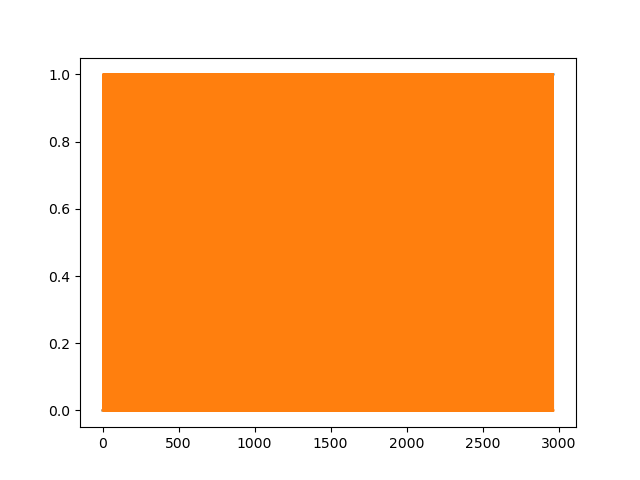

In [14]:
clear_output()
%matplotlib widget
fig = plt.figure()
plt.plot(timelineTimestamps, neuralFrames/max(neuralFrames))
plt.plot(timelineTimestamps, changeFrames)
plt.show()

In [ ]:
# vrdb.updateSuite2pDateTime()
# vrdb.checkS2P(withDatabaseUpdate=True)

In [ ]:
vrdb.printRequiresS2P(needsQC=True)

Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-18/701
Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-20/701
Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-20/702
Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-23/701
Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-24/703
Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-25/701
Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-26/702
Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-27/701
Database indicates that suite2p has been run but not QC'd: ATL012/2023-01-30/702
Database indicates that suite2p has been run but not QC'd: ATL012/2023-02-01/701
Database indicates that suite2p has been run but not QC'd: ATL012/2023-02-02/701
Database indicates that suite2p has been run but not QC'd: ATL012/2023-02-06/701
Database indicates that suit

In [3]:
import PyQt5

In [6]:
dir(PyQt5)

['QtCore',
 'QtGui',
 'QtSvg',
 'QtWidgets',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'sip']